# Kernel Predicting Convolutional Networks for Denoising Monte Carlo Renderings
*Original Paper: http://civc.ucsb.edu/graphics/Papers/SIGGRAPH2017_KPCN/PaperData/SIGGRAPH17_KPCN.pdf*  
*TensorFlow Implementation by **Brian Hoy***  
*Training data by **Matthew Woerner***  

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from sklearn.feature_extraction import image
import numpy as np
import imageio
import math
import IPython.display
import PIL
import os

In [2]:
gpus = tf.config.list_physical_devices('GPU')

# try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
# except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

K.set_floatx('float32')

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Parameters for learning
mode = "kpcn" # "kpcn" or "dpcn"
patch_size = 64
mini_batch_size = 4 if mode == "kpcn" else 5 # KPCN requires much more video memory so we have to reduce batch size :(
percent_used_for_validation = 0.1
learning_rate = 10e-6
output_kernel_size = 17
enable_albedo_div = True
checkpoint_path = "training_" + mode + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
restore_from_checkpoint = True

In [4]:
def make_3_channels(image):
    if image.ndim == 2: image = np.dstack((image, image, image))
    if image.shape[2] == 1: 
        image = np.reshape(image, (64, 64))
        image = np.dstack((image, image, image))
    image = image[:,:,:3]
    return image

# somewhat based off the getVarianceMap function from https://github.com/Nidjo123/kpcn
def preprocess_variance(variance):
    variance = variance.max(axis=2)
    variance = np.minimum(variance**(1.0/2.2), 1.0)
    variance = variance / variance.max()
    return variance
    
def preprocess_color(color, albedo, epsilon=0.1):
    return color.astype(np.float32) / (albedo + epsilon)

def postprocess_color(color, albedo, epsilon=0.1):
    return color * (albedo + epsilon)

def preprocess_color_variance(variance, albedo, epsilon=0.1):
    variance = variance / (albedo + epsilon)**2
    return preprocess_variance(variance)
    
def calculate_gradient(image):
    y, x, c = image.shape
    dx = image[:, 1:, :] - image[:, :x-1, :]
    dy = image[1:, :, :] - image[:y-1, :, :]
    dx = np.append(dx, np.zeros([y, 1, c]), axis=1)
    dy = np.append(dy, np.zeros([1, x, c]), axis=0)
    grad = np.dstack((dx, dy))
    return grad

def load_highspp(folder_path):
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    color = make_3_channels(imageio.imread(folder_path + "/final.png").astype(np.float32))
    if enable_albedo_div:
        color = preprocess_color(color, albedo)
    
    combined = np.dstack((color, albedo))
    combined = combined.astype(np.float16)
    assert not np.any(np.isnan(combined))
    return combined

def load_lowspp(folder_path, return_channels=False):
    print("loading " + folder_path)

    # albedo buffers
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    albedo_variance = make_3_channels(imageio.imread(folder_path + "/albedoVariance.png").astype(np.float32))
    albedo_variance = preprocess_variance(albedo_variance)
    albedo_gradient = calculate_gradient(albedo)

    # color buffers
    color = make_3_channels(imageio.imread(folder_path + "/final.png").astype(np.float32))
    if enable_albedo_div:
        color = preprocess_color(color, albedo)
    color_variance = make_3_channels(imageio.imread(folder_path + "/colorVariance.png").astype(np.float32))
    if enable_albedo_div:
        color_variance = preprocess_color_variance(color_variance, albedo)
    else:
        color_variance = preprocess_variance(color_variance)

    color_gradient = calculate_gradient(color)

    # depth buffers
    depth = imageio.imread(folder_path + "/depth.png").astype(np.float32)
    depth = depth.reshape((depth.shape[0], depth.shape[1], 1))
    depth_variance = make_3_channels(imageio.imread(folder_path + "/depthVariance.png").astype(np.float32))
    depth_variance = preprocess_variance(depth_variance)
    # depth_gradient = calculate_gradient(depth)

    # normal buffers
    normal = make_3_channels(imageio.imread(folder_path + "/normal.png").astype(np.float32))
    normal_variance = make_3_channels(imageio.imread(folder_path + "/normalVariance.png").astype(np.float32))
    normal_variance = preprocess_variance(normal_variance)
    # normal_gradient = calculate_gradient(normal)
    
    normal_variance = normal_variance.reshape((normal_variance.shape[0], normal_variance.shape[1], 1))
    color_variance = color_variance.reshape((color_variance.shape[0], color_variance.shape[1], 1))
    albedo_variance = albedo_variance.reshape((albedo_variance.shape[0], albedo_variance.shape[1], 1))
    depth_variance = depth_variance.reshape((depth_variance.shape[0], depth_variance.shape[1], 1))

    chans = (color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance)
    chans_str = "color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance".split(", ")
    names_and_channels = []
    if return_channels:
        for i in range(len((chans))):
            names_and_channels.append((chans_str[i], chans[i].shape[2]))
    
    combined = np.dstack((color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance))
    combined = combined.astype(np.float16)
    assert not np.any(np.isnan(combined))
    
    if return_channels:
        return combined, names_and_channels
    
    return combined

In [5]:
def imshow(data, display_image=True):
    data = np.clip(data, 0.0, 255.0).astype(np.uint8)
    pil_img = PIL.Image.fromarray(data, 'RGB')
    if display_image:
        display(pil_img)
    return pil_img

def imshow_pp(data, display_image=True):
    if enable_albedo_div:
        data = postprocess_color(data[:,:,:3], data[:,:,3:])
    return imshow(data[:,:,:3], display_image=display_image)

In [6]:
def extract_patches(image):
    half_patch_size = patch_size//2
    x_patches = image.shape[1]//patch_size
    x_patches = x_patches + x_patches - 1
    y_patches = image.shape[0]//patch_size
    y_patches = y_patches + y_patches - 1
    add_extra_x_patch = (image.shape[1] % patch_size) != 0
    add_extra_y_patch = (image.shape[0] % patch_size) != 0
    patches = []
    
    xstart = 0
    xend = 0
    for x in range(x_patches):
        xstart = x * half_patch_size
        xend = xstart + patch_size
        for y in range(y_patches):
            ystart = y * half_patch_size
            yend = ystart + patch_size
            patches.append(image[ystart:yend, xstart:xend, :])
            
        # add one more vertical patch if needed
        if add_extra_y_patch:
            patches.append(image[image.shape[0]-patch_size:, xstart:xend, :])
    
    if add_extra_x_patch:
        for y in range(y_patches):
            ystart = y * half_patch_size
            yend = ystart + patch_size
            temp = image[ystart:yend, image.shape[1]-patch_size:, :]
            patches.append(temp)
        if add_extra_y_patch:
            patches.append(image[image.shape[0]-patch_size:, xstart:xend, :])

    return patches

def reassemble_patches(patches, image_shape):
    image = None
    
    half_patch_size = patch_size//2
    x_patches = image_shape[1]//patch_size
    x_patches = x_patches + x_patches - 1
    y_patches = image_shape[0]//patch_size
    y_patches = y_patches + y_patches - 1
    add_extra_x_patch = (image_shape[1] % patch_size) != 0
    add_extra_y_patch = (image_shape[0] % patch_size) != 0
    x_patches = x_patches + 1 if add_extra_x_patch else x_patches
    y_patches = y_patches + 1 if add_extra_x_patch else y_patches
    patches = np.vstack(patches)
    height = y_patches * half_patch_size
    final = patches[:height,:,:]
    height = y_patches * half_patch_size    
    for i in range(1, x_patches, 1):
        final = np.hstack((final, patches[i*height:(i+1)*height,:,:]))
    return final

In [7]:
# note to self: use this https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets
def load_x_y_patches():
    x_patches = []
    y_patches = []
    y_patches_with_albedo = []
    orig = next(os.walk('./pngs'))[1]
    folders = [x[0:x.rindex('16')] for x in orig if '16' in x]

    for x in folders:
        low_spp = load_lowspp('./pngs/' + x + '16')
        high_spp = load_highspp('./pngs/' + x + '4096')
        temp_x_patches = extract_patches(low_spp)
        temp_y_patches = extract_patches(high_spp)

        for i in range(len(temp_x_patches)):
            x_patches.append(temp_x_patches[i])
            y_patches.append(temp_y_patches[i][16:-16,16:-16,:3])
            y_patches_with_albedo.append(temp_y_patches[i])

    return x_patches, y_patches, y_patches_with_albedo


In [8]:
x_patches, y_patches, y_patches_with_albedo = load_x_y_patches()

loading ./pngs/bathroom16
loading ./pngs/bathroom2-16
loading ./pngs/bedroom-16
loading ./pngs/car-16
loading ./pngs/car2-16
loading ./pngs/classroom-16
loading ./pngs/coffee-16
loading ./pngs/cornell-box-16
loading ./pngs/curly-hair-16
loading ./pngs/dining-room-16
loading ./pngs/dragon-16
loading ./pngs/furball-16
loading ./pngs/hair-curl-16
loading ./pngs/house-16
loading ./pngs/kitchen-16
loading ./pngs/lamp-16
loading ./pngs/living-room-16
loading ./pngs/living-room-2-16
loading ./pngs/living-room-3-16
loading ./pngs/material-testball-16
loading ./pngs/spaceship-16
loading ./pngs/staircase-16
loading ./pngs/staircase2-16
loading ./pngs/straight-hair-16
loading ./pngs/teapot-16
loading ./pngs/teapot-full-16
loading ./pngs/veach-ajar-16
loading ./pngs/veach-mis-16


x patch shape: (64, 64, 26)
loading ./pngs/bathroom16
color div albedo


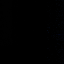

color


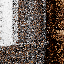

albedo


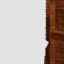

color_gradient x


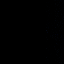

color_gradient y


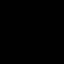

albedo_gradient x


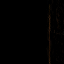

albedo_gradient y


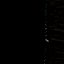

depth


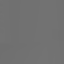

normal


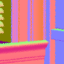

color_variance


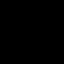

albedo_variance


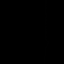

depth_variance


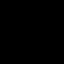

normal_variance


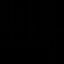

y label: shape: (32, 32, 3)


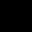

In [9]:
def preview_input_channels(patch_number=360):
    print("x patch shape: " + str(x_patches[0].shape))
    img, names_and_channels = load_lowspp("./pngs/bathroom16", return_channels=True)
    patch = x_patches[patch_number]
    
    if enable_albedo_div:
        print("color div albedo")
        imshow(patch[:,:,:3])
        print("color")
        imshow_pp(patch[:,:,:6])
    else:
        print("color")
        imshow(patch[:,:,:3])
    
    i = 3
    for name, channels in names_and_channels[1:]:
        if channels == 6:
            channels = 3
            print(name + " x")
            imshow(make_3_channels(patch[:,:,i:(i+channels)]))
            i = i + channels
            print(name + " y")
            imshow(make_3_channels(patch[:,:,i:(i+channels)]))
            i = i + channels

        else:
            print(name)
            imshow(make_3_channels(patch[:,:,i:(i+channels)]))
            i = i + channels
        
    print("y label: shape: " + str(y_patches[0].shape))
    imshow(y_patches[patch_number][:,:,:])

preview_input_channels()

In [10]:
# Custom Keras layer to apply the kernel to noisy input
# Works by shifting the input then multiplying it by the appropriate weight
# Note that all weights will be between 0 and 1 due to the softmax activation of previous layer

halfsize = output_kernel_size//2

class KernelApply2D(tf.keras.layers.Layer):
    def __init__(self):
        super(KernelApply2D, self).__init__()

    def call(self, input):
        w = input[:,16:-16,16:-16,3:]
        w = tf.stack([w, w, w], axis=3)
        y = input[:,:,:,:3]
        z = input[:,16:-16,16:-16,:3]*0

        for i in range(output_kernel_size):
            for j in range(output_kernel_size):
                shifted_input = y[:,16-halfsize+j:-16-halfsize+j,16-halfsize+i:-16-halfsize+i]
                z = z + shifted_input * w[:,:,:,:,i*3 + j]

        return z

# Tests kernel apply layer by applying a simple edge detection kernel
def test_kernel_apply_2D():
    global output_kernel_size, halfsize
    old_output_kernel_size = output_kernel_size
    output_kernel_size = 3
    halfsize = output_kernel_size//2
    layer = KernelApply2D()
    # xpatch = y_patches[405][:,:,:3]
    # print(xpatch.dtype)
    xpatch = tf.ones((32,32,3), dtype=tf.float16) * 255.0
    xpatch = tf.pad(xpatch, [[16, 16], [16, 16], [0, 0]], "CONSTANT")
    x = xpatch[:,:,0]
    x = tf.repeat(x, 3)

    x = tf.reshape(x, (1, 64, 64, 3))
    w = tf.constant([1.0, 2.0, 1.0, 0.0, 0.0, 0.0, -1.0, -2.0, -1.0], dtype=tf.float16)
    w = tf.reshape(w, (1, 1, 1, 9))
    w = tf.tile(w, tf.constant([1, 64, 64, 1]))

    x = tf.concat([x, w], axis=3)
    predicted = layer(x)[0]

    imshow(xpatch)
    z = imshow(predicted)
    output = layer(x)
    output[0,0,0]
    output_kernel_size = old_output_kernel_size
    halfsize = output_kernel_size//2

# test_kernel_apply_2D()

In [11]:
# I could not find a built in keras layer to crop the channels so I made a really simple one... used for extracting color channels from input
class ChannelCroppingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ChannelCroppingLayer, self).__init__()

    def call(self, input):
        return input[:,:,:,:3]

In [12]:
def make_nn(input_channels):
    #basic model parameters
    L = 9
    kernel_size = 5
    hidden_channels = 100
    in_between_layers = L - 2

    # add layers
    noisy_input = keras.Input(shape=(patch_size, patch_size, input_channels))
    x = noisy_input
    for i in range(in_between_layers):
#         x = layers.ZeroPadding2D(padding=(2, 2))(x)
        x = layers.Conv2D(hidden_channels, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu")(x)

#     x = layers.ZeroPadding2D(padding=(2, 2))(x)
    
    if mode == "kpcn":
        cropped_noisy_input = ChannelCroppingLayer()(noisy_input)
        x = layers.Conv2D(output_kernel_size**2, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="softmax")(x)
        x = layers.ZeroPadding2D(padding=(16, 16))(x)
        x = layers.concatenate([cropped_noisy_input, x])
        x = KernelApply2D()(x)
    else:
        x = layers.Conv2D(3, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu")(x)
    
    # compile model
    model = keras.Model(inputs=[noisy_input], outputs=[x])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error'])

    return model

model = make_nn(x_patches[0].shape[2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 26)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 100)  65100       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 100)  250100      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 52, 52, 100)  250100      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
def create_tf_dataset(x_patches, y_patches):
    validate_amount = math.floor(len(x_patches) * percent_used_for_validation)
    rec_count = len(x_patches)
    ds = tf.data.Dataset.from_tensor_slices((x_patches, y_patches))
    ds = ds.shuffle(buffer_size=400, reshuffle_each_iteration=True)
    train = ds.skip(validate_amount).batch(mini_batch_size)
    validate = ds.take(validate_amount).batch(mini_batch_size)
    return train, validate

In [ ]:
train, validate = create_tf_dataset(x_patches, y_patches)

In [ ]:
# if restore_from_checkpoint:
#     latest = tf.train.latest_checkpoint(checkpoint_dir)
#     model.load_weights(latest)
#     model

In [ ]:
def test_model(lowspp_imagedir, highspp_imagedir, display_image=False):
    lowspp = load_lowspp(lowspp_imagedir)
    highspp = load_highspp(highspp_imagedir)
    x_patches = extract_patches(lowspp)
    y_patches = extract_patches(highspp)
    pred_patches = []
    for i in range(len(x_patches)):
        patch_x = x_patches[i]
        patch_y = y_patches[i]
        predicted = model.predict(patch_x.reshape((1, patch_size, patch_size, patch_x.shape[2])))[0]
        if enable_albedo_div:
            predicted = np.dstack((predicted, patch_y[16:-16,16:-16,3:]))
        pred_patches.append(predicted)
    image = reassemble_patches(pred_patches, lowspp.shape)
    return imshow_pp(image, display_image=display_image)

In [ ]:
def display_and_save_image(patch_number=360, epoch=-1):
    xpatch = x_patches[patch_number]
    xpatchcolor = xpatch[:,:,:6]
    gt = y_patches_with_albedo[patch_number]
    predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
    if enable_albedo_div:
        predicted = np.dstack((predicted, gt[16:-16,16:-16,3:]))
        imshow_pp(xpatchcolor).save(checkpoint_dir + '/epoch_' + str(epoch) + '_xpatch.png')
        imshow_pp(gt).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt.png')
        imshow(gt[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt_divalbedo.png')
        imshow_pp(predicted).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction.png')
        imshow(predicted[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction_divalbedo.png')
    else:
        imshow(xpatchcolor[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_xpatch.png')
        imshow(gt[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt.png')
        imshow_pp(predicted[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction.png')

class DisplayImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DisplayImageCallback, self).__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        display_and_save_image(epoch=epoch)
        if epoch % 3 == 0:
            test_model('./pngs/bathroom16', './pngs/bathroom4096', display_image=False).save(checkpoint_dir + '/bathroom/epoch_' + str(epoch) + '_predicted.png')

print("Model without any training")
display_and_save_image()
test_model('./pngs/bathroom16', './pngs/bathroom4096', display_image=True).save(checkpoint_dir + '/bathroom/epoch_' + str(-5) + '_predicted_full_bathroom.png')

In [ ]:
print("Fit model on training data")
image_cb = DisplayImageCallback()
history_cb = tf.keras.callbacks.CSVLogger(checkpoint_dir + '/log.csv', separator=",", append=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    train,
    validation_data=validate,
    epochs=10000,
    callbacks=[cp_callback, history_cb, image_cb]
)

## References
To make this I used:
1) the TensorFlow/Keras Documentation
2) the KPCN paper (http://civc.ucsb.edu/graphics/Papers/SIGGRAPH2017_KPCN/PaperData/SIGGRAPH17_KPCN.pdf)
3) a PyTorch KPCN implementation I found on Google (https://github.com/Nidjo123/kpcn) to validate that structure of my CNN is correct as well as see how they preprocessed images

In [ ]:
# Random Testing Code

In [ ]:
lowspp = load_lowspp('./pngs/coffee-16')

In [ ]:


patches = extract_patches(lowspp)
patches = [x[16:-16, 16:-16, :] for x in patches]
print(patches[0].shape)
len(patches)
rebuilt = reassemble_patches(patches, lowspp.shape)
imshow(rebuilt[:,:,:3])
print(rebuilt.shape)

In [ ]:
test_model('./pngs/bathroom16', './pngs/bathroom4096').save(checkpoint_dir + '/epoch_' + str(-2) + '_predicted_full_bathroom.png')

In [ ]:
# patches = extract_patches(lowspp)
# rebuilt = reassemble_patches(patches, lowspp.shape)
# imshow_pp(rebuilt[:,:,:6])